# Analyzing Venues Data of Seoul for Foodies

## Table of contents
* [Part 1: Introduction](#introduction)
* [Part 2: Data](#data)
* [Part 3: Methodology](#methodology)
* [Part 4: Results and Discussion](#results)
* [Part 5: Conclusion](#conclusion)

## Part 1: Introduction <a name="introduction"></a>

This project will be targeted at people who are interested in exploring Seoul, South Korea. Most specifically, for foodies who like to explore a different eatery every week. 

I will use my limited data science knowledge to do the following:

1) Prepare the data (loading data, plotting map, finding venues with the help of FourSquare API)

2) Analyze the data (k-means clustering)

This notebook focuses more on coding, the more detailed discussion can be found in the report and the presentation. 

## Part 2: Data<a name="data"></a>

Import the necessary libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt 

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import folium # map rendering library

Load the dataframe containing the districts and their corresponding geographical coordinates

In [2]:
seoul = pd.read_excel("Seoul.xlsx") 
print(seoul.shape)
seoul.head()

(25, 4)


,Korean,District,Latitude,Longitude
0,종로구,Jongno,37.580310,126.983079
1,중구,Jung,37.563656,126.997510
2,용산구,Yongsan,37.532300,126.990000
3,성동구,Seongdong,37.563500,127.036500
4,광진구,Gwangjin,37.538400,127.082800


Get the geographical coordinates of Seoul using geopy library, and create map of Seoul with the districts superimposed on top

In [3]:
# Getting the geographical coordinates of Seoul
address = '서울, 대한민국'
geolocator = Nominatim(user_agent="KR_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# Plotting the map
map_seoul = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(seoul['Latitude'], seoul['Longitude'], seoul['District']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_seoul)  

print('The geographical coordinates of Seoul are {}, {}.'.format(latitude, longitude))    
map_seoul

The geographical coordinates of Seoul are 37.5666791, 126.9782914.


#### FourSquare API

In [4]:
# Define FourSquare API credentials
CLIENT_ID = 'Hidden' # your Foursquare ID
CLIENT_SECRET = 'Hidden' # will be reset perodically
VERSION = '20180605' # Foursquare API version

# Define a function to get the nearby venues
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# Run the above function on each district and create a new dataframe
LIMIT = 200 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

seoul_venues = getNearbyVenues(names=seoul['District'],
                                   latitudes=seoul['Latitude'],
                                   longitudes=seoul['Longitude']
                                  )

Jongno
Jung
Yongsan
Seongdong
Gwangjin
Dongdaemun
Jungnang
Seongbuk
Gangbuk
Dobong
Nowon
Eunpyeong
Seodaemun
Mapo
Yangcheon
Gangseo
Guro
Geumcheon
Yeongdeung
Dongjak
Gwanak
Seocho
Gangnam
Songpa
Gangdong


Check the size of the resulting dataframe

In [5]:
print(seoul_venues.shape)
seoul_venues.head()

(722, 7)


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Jongno,37.58031,126.983079,Baek In-Je House Museum (백인제가옥),37.580508,126.984164,Historic Site
1,Jongno,37.58031,126.983079,KIWA TAPROOM (기와탭룸),37.578711,126.981770,Brewery
2,Jongno,37.58031,126.983079,Blue Bottle Coffee (블루보틀),37.580143,126.980845,Coffee Shop
3,Jongno,37.58031,126.983079,Wood & Brick (우드앤브릭),37.579413,126.984166,Bakery
4,Jongno,37.58031,126.983079,MIRROR ROOM (미러룸),37.579933,126.981078,Coffee Shop


There are 722 venues detected. The next thing is to find out how many venues were returned for each district and how many unique categories are the venues classified into.

In [6]:
print('There are {} unique categories of venues.'.format(len(seoul_venues['Venue Category'].unique())))
seoul_venues.groupby('District').count().head()

There are 133 unique categories of venues.


,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
Dobong,10,10,10,10,10,10
Dongdaemun,17,17,17,17,17,17
Dongjak,36,36,36,36,36,36
Eunpyeong,8,8,8,8,8,8
Gangbuk,19,19,19,19,19,19


## Part 3: Methodology<a name="methodology"></a>

After loading the data containing the districts of Seoul, I have created a map of Seoul with the markers representing the districts superimposed on the map. I have also generated the date for the venues detected by Foursquare API.

The next thing is to analyze the top venues and cluster the districts based on the top venues. The clustering method used in k-means clustering. The clusters will then be represented on the map. 

### Analysis

Encode categorical integer features using a one-hot aka one-of-K scheme.

In [7]:
# one hot encoding
seoul_onehot = pd.get_dummies(seoul_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
seoul_onehot['District'] = seoul_venues['District'] 

# move neighborhood column to the first column
fixed_columns = [seoul_onehot.columns[-1]] + list(seoul_onehot.columns[:-1])
seoul_onehot = seoul_onehot[fixed_columns]

# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
seoul_grouped = seoul_onehot.groupby('District').mean().reset_index()

num_top_venues = 5

for hood in seoul_grouped['District']:
    print("----"+hood+"----")
    temp = seoul_grouped[seoul_grouped['District'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Dobong----
              venue  freq
0              Café   0.2
1        Donut Shop   0.1
2    Ice Cream Shop   0.1
3  Sushi Restaurant   0.1
4     Big Box Store   0.1


----Dongdaemun----
               venue  freq
0          BBQ Joint  0.53
1  Korean Restaurant  0.18
2         Donut Shop  0.06
3             Market  0.06
4           Bus Stop  0.06


----Dongjak----
                  venue  freq
0    Seafood Restaurant  0.17
1     Korean Restaurant  0.14
2  Fast Food Restaurant  0.08
3           Coffee Shop  0.08
4        Ice Cream Shop  0.06


----Eunpyeong----
              venue  freq
0    Ice Cream Shop  0.12
1            Bakery  0.12
2       Coffee Shop  0.12
3      Concert Hall  0.12
4  Sushi Restaurant  0.12


----Gangbuk----
          venue  freq
0   Coffee Shop  0.21
1    Donut Shop  0.16
2     Multiplex  0.11
3        Bakery  0.05
4  Dessert Shop  0.05


----Gangdong----
               venue  freq
0  Korean Restaurant  0.21
1        Coffee Shop  0.11
2   Asian Restaurant  

Write a function to sort the venues in descending order and create a new dataframe displaying the top 5 venues for each district

In [8]:
# Function to return the most common values
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

# Run the function
num_top_venues = 5
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
districts_venues_sorted = pd.DataFrame(columns=columns)
districts_venues_sorted['District'] = seoul_grouped['District']

for ind in np.arange(seoul_grouped.shape[0]):
    districts_venues_sorted.iloc[ind, 1:] = return_most_common_venues(seoul_grouped.iloc[ind, :], num_top_venues)

districts_venues_sorted.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Dobong,Café,Fast Food Restaurant,Big Box Store,Ice Cream Shop,Burger Joint
1,Dongdaemun,BBQ Joint,Korean Restaurant,Supermarket,Donut Shop,Ice Cream Shop
2,Dongjak,Seafood Restaurant,Korean Restaurant,Coffee Shop,Fast Food Restaurant,Ice Cream Shop
3,Eunpyeong,Bakery,Clothing Store,Ice Cream Shop,Coffee Shop,Concert Hall
4,Gangbuk,Coffee Shop,Donut Shop,Multiplex,Fast Food Restaurant,Bus Stop


#### Clustering the districts using k-means clustering

Firstly, use the "elbow" method to find the optimal k value. 

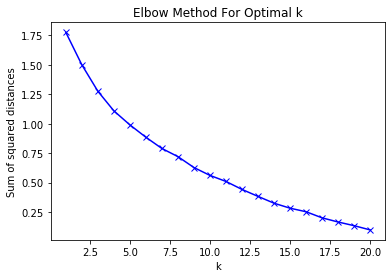

In [18]:
seoul_grouped_clustering = seoul_grouped.drop('District', 1)

Sum_of_squared_distances = []
K = range(1,21)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(seoul_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

From the plot above, the "elbow" is not very obvious. So this means that I need to use the silhouette score. I will exclude k=2 because I want a wide segmentation of the districts.

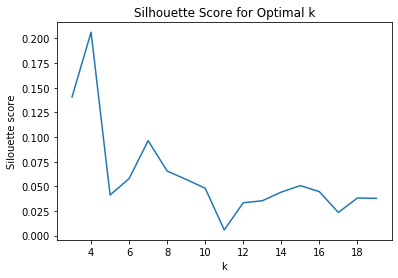

In [12]:
#Use silhouette score
range_n_clusters = list(range(3,20))
silhouette_score_values =[]

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(seoul_grouped_clustering)
    centers = clusterer.cluster_centers_
    score = silhouette_score(seoul_grouped_clustering, preds)
    silhouette_score_values.append(score)
    
plt.plot(range_n_clusters, silhouette_score_values)
plt.xlabel('k')
plt.ylabel('Silouette score')
plt.title('Silhouette Score for Optimal k')
plt.show()

Based on the silhouette score, optimal k is 4. There, I will run k means with k=4 and visualize the clusters on the map.

In [13]:
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(seoul_grouped_clustering)

# add clustering labels
districts_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

seoul_merged = seoul

# merge seoul_grouped with seoul_data to add latitude/longitude for each district
seoul_merged = seoul_merged.join(districts_venues_sorted.set_index('District'), on='District')

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(seoul_merged['Latitude'], seoul_merged['Longitude'], seoul_merged['District'], seoul_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examining the Clusters

In [14]:
# Cluster 1
seoul_merged.loc[seoul_merged['Cluster Labels'] == 0, seoul_merged.columns[[1] + list(range(5, seoul_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Jung,Korean Restaurant,Hotel,Coffee Shop,Noodle House,Bakery
4,Gwangjin,Coffee Shop,Korean Restaurant,Bunsik Restaurant,Gukbap Restaurant,Snack Place
15,Gangseo,Korean Restaurant,Chinese Restaurant,Grocery Store,Sushi Restaurant,Noodle House
24,Gangdong,Korean Restaurant,Asian Restaurant,Coffee Shop,Bakery,Steakhouse


In cluster 1, the most common venue for the 4 districts is Korean restaurant.

In [15]:
# Cluster 2
seoul_merged.loc[seoul_merged['Cluster Labels'] == 1, seoul_merged.columns[[1] + list(range(5, seoul_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Jongno,Korean Restaurant,Café,Coffee Shop,Bakery,Art Gallery
2,Yongsan,Bar,Korean Restaurant,Pub,Coffee Shop,Lounge
3,Seongdong,Coffee Shop,Korean Restaurant,Seafood Restaurant,Bakery,Vietnamese Restaurant
6,Jungnang,Trail,Coffee Shop,Bakery,Bubble Tea Shop,Fast Food Restaurant
7,Seongbuk,Korean Restaurant,Japanese Restaurant,Coffee Shop,Café,Gym / Fitness Center
8,Gangbuk,Coffee Shop,Donut Shop,Multiplex,Fast Food Restaurant,Bus Stop
9,Dobong,Café,Fast Food Restaurant,Big Box Store,Ice Cream Shop,Burger Joint
10,Nowon,Coffee Shop,Steakhouse,Multiplex,Farmers Market,Fast Food Restaurant
11,Eunpyeong,Bakery,Clothing Store,Ice Cream Shop,Coffee Shop,Concert Hall
12,Seodaemun,Health Food Store,Chinese Restaurant,Gym Pool,Gym,Other Great Outdoors


In cluster 2, the most common venue in common for these district is either a cafe or a coffee shop, or both. The exception is Seodaemun district, this is probably because the next most common venue is restaurant in general.

In [16]:
# Cluster 3
seoul_merged.loc[seoul_merged['Cluster Labels'] == 2, seoul_merged.columns[[1] + list(range(5, seoul_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
17,Geumcheon,Chinese Restaurant,Bus Stop,Bakery,Grocery Store,Clothing Store


Geumcheon is singled out for cluster 3. This is probably because it is the only district where the first two most common venues are a Chinese restaurant and a bus stop.

In [17]:
# Cluster 4
seoul_merged.loc[seoul_merged['Cluster Labels'] == 3, seoul_merged.columns[[1] + list(range(5, seoul_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,Dongdaemun,BBQ Joint,Korean Restaurant,Supermarket,Donut Shop,Ice Cream Shop


Dongdaemun is the only district where the first most common venue is a BBQ Joint.

## Part 4: Results and Discussion<a name="results"></a>

The k-means clustering method has resulted in one large cluster, smaller cluster and two standalone districts. The majority of Seoul's districts have coffee shops and cafes as the most common venues.

The next most common venue is Korean restaurant. This is expected because this is South Korea. It also shows that Korean people really love their native cuisine.

For all the four clusters, at least 4 out of 5 of the top venues are eateries, there is approximately 578 eateries out of the 722 venues detected by FourSquare API. The actual number of eateries should be even higher. As a foodie, one would be spoilt for choice to choose where to go for a meal.

If one wants to visit a coffee shop or cafe, I would recommend Gwangjin, Seongdong, Gangbuk, Dobong, Nowon and Seocho districts. This is because these are the districts where the number one most common venue is either a coffee shop or cafe.

If one wants to visit a Korean restaurant, I would recommend Jung, Gangseo, Gangdong, Jongno, Seongbok, Yangcheon, Yeongdeung and Songpa. This is because these are the districts where the number one most common venue is a Korean restaurant.

## Part 5: Conclusion<a name="conclusion"></a>

Purpose of this project was to identify the most common venues within each of the 25 districts of Seoul. Clustering of those venues was then performed in order to create clusters in which the districts share common top venues. The method of clustering is k-means clustering.

Analysis shows that the majority of the most common venues detected by FourSquare API in this project are eateries. This is a good news for foodies who like to explore a different eatery every week or even everyday in Seoul. The top 3 most common venues are coffee shops, cafes and Korean restaurants.